
---

# Introduction

Thank you for taking the time to review my **CSCA-5622 project**. This project explores and compares multiple **supervised machine learning techniques** to assess their effectiveness in addressing a **text classification** task within the context of IT support operations.

By way of background, I currently work in the IT field and approached this project as an initial step toward developing a model capable of **automatically classifying IT service requests**. The broader goal is to design a system that can **intelligently route incoming support tickets** to the appropriate personnel or automated agents, thereby streamlining the triage process and improving operational efficiency.

For this study, I selected the publicly available [IT Service Ticket Classification Dataset](https://www.kaggle.com/datasets/adisongoh/it-service-ticket-classification-dataset?resource=download), which contains a labeled corpus of real-world IT support tickets. These tickets closely resemble the types of requests I encounter in my professional environment, making the dataset a relevant choice for this use case. Due to its size (~14 MB), the raw `.csv` file is not included in this repository; however, it can be downloaded directly from the Kaggle link provided for those wishing to replicate or extend this work.

---

## Problem Statement

In enterprise IT environments, service requests vary widely in nature and often require domain-specific expertise for resolution. For instance:

- A systems administrator may be responsible for resolving technical faults related to Infrastructure Component A.  
- An AI-driven agent may handle standardized access requests for Platform B.  

In the absence of an automated classification system, such tickets must be manually reviewed and routed to the appropriate resolver group. This manual triage process is not only time-consuming but also introduces the risk of misclassification and delayed resolution.

The aim of this project is to investigate how **machine learning models** can be trained to **automatically classify and route IT support tickets** based on their content. This approach has the potential to significantly reduce human intervention, improve accuracy, and accelerate the overall support workflow.

The scope of this project is limited to **supervised learning methods** introduced in this course. Although more complex architectures (e.g., neural networks) may yield further performance gains, this study is intentionally focused on classical supervised learning techniques covered in the curriculum, in order to evaluate their applicability and effectiveness in this domain.

---


## Exploratory Data Analysis

### Import Data

In [2]:
import pandas as pd

all_tickets = pd.read_csv('all_tickets_processed_improved_v3.csv')
print(all_tickets.head())
print(f"\n{all_tickets.shape[0]} rows and {all_tickets.shape[1]} columns")

                                            Document    Topic_group
0  connection with icon icon dear please setup ic...       Hardware
1  work experience user work experience user hi w...         Access
2  requesting for meeting requesting meeting hi p...       Hardware
3  reset passwords for external accounts re expir...         Access
4  mail verification warning hi has got attached ...  Miscellaneous

47837 rows and 2 columns


The `all_tickets` DataFrame consists of two key columns:  
+ **`Document`** – containing the textual content of IT support requests.  
+ **`Topic_group`** – indicating the category or type of each request, which corresponds to the intended routing decision.

In this project, we will approach the classification task as follows:

+ Use the text in the `Document` column as the **input features (X)** for our model.  
+ Use the `Topic_group` column as the **target variable (y)**, representing the classification labels that our model aims to predict.

### Distribution of IT Support Request Categories

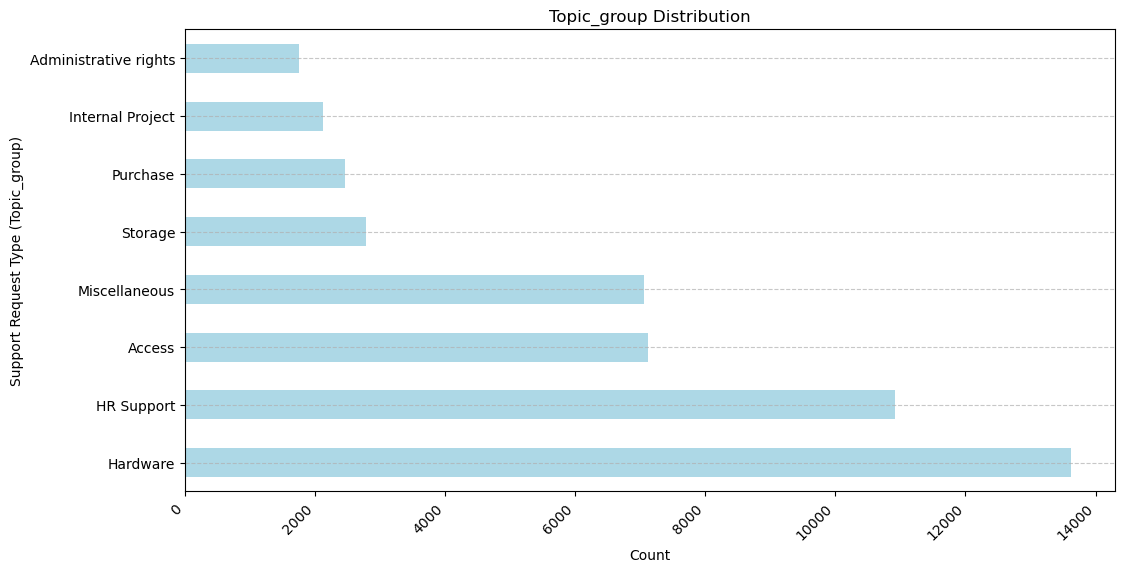

In [34]:
import matplotlib.pyplot as plt

topic_group_counts = all_tickets["Topic_group"].value_counts()

plt.figure(figsize=(12, 6))
topic_group_counts.plot(kind="barh", color='lightblue')
plt.xlabel("Count")
plt.ylabel("Support Request Type (Topic_group)")
plt.title("Topic_group Distribution")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

The distribution of support request categories is imbalanced, with "Hardware" and "HR Support" appearing significantly more frequently than other classes. To maintain consistency and avoid introducing bias, it is important to ensure that both the training and testing datasets reflect this same distribution.

### Bag-of-Words Text Representation

We will utilize the [Bag-of-Words (BoW)](https://en.wikipedia.org/wiki/Bag-of-words_model) technique for encoding the `Document` text into numerical form.

To give examples from rows 238, 307, and 338 in `all_tickets`:

| Row # | `Document` text                              |
|-------|---------------------------------------------|
| 238   | access re please provide also thanks       |
| 307   | account for hi please create thank head    |
| 338   | access great hi please mailbox thank       |

The Bag-of-Words (BoW) encoding transforms each row of text into a vector where every unique word from the entire corpus is assigned its own column. The values in these columns represent the frequency (i.e., word count) of each word in the corresponding document.

| Row # | access | re | please | provide | also | thanks | account | for | hi | create | thank | head | great | mailbox |
|-------|--------|----|--------|---------|------|--------|---------|----|----|--------|-------|------|-------|---------|
| 238   | 1      | 1  | 1      | 1       | 1    | 1      | 0       | 0  | 0  | 0      | 0     | 0    | 0     | 0       |
| 307   | 0      | 0  | 1      | 0       | 0    | 0      | 1       | 1  | 1  | 1      | 1     | 1    | 0     | 0       |
| 338   | 1      | 0  | 1      | 0       | 0    | 0      | 0       | 0  | 1  | 0      | 1     | 0    | 1     | 1       |


## Data Preparation

Before converting the `Document` column into a bag-of-words matrix, we use the [spaCy library](https://spacy.io/) to preprocess the text by performing the following steps:

- [Tokenization](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization): breaking the text into individual words or tokens  
- [Stopword removal](https://en.wikipedia.org/wiki/Stop_word): filtering out common words like "the", "a", and "an" that carry little meaningful information  
- [Lemmatization](https://en.wikipedia.org/wiki/Lemmatization): reducing words to their base or root form (e.g., "running" becomes "run")

These preprocessing steps help improve both the accuracy and efficiency of the model. By eliminating words with low semantic value, we reduce noise in the dataset and allow the model to focus on the more informative terms that are likely to influence classification decisions.

In [4]:
import spacy
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    doc = nlp(text.lower())
    cleaned_tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(cleaned_tokens)

all_tickets["Document"] = all_tickets["Document"].apply(preprocess_text)

Next, we transform the `Document` column in `all_tickets` into a bag-of-words matrix (X). Then we form a new data frame called `all_tickets_bow_df` rejoining X with the `Topic_group` dependent variable (y).

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract the Document and Topic_group columns from all_tickets
documents = all_tickets["Document"]
y = all_tickets["Topic_group"]

# Apply Bag-of-Words transformation
vectorizer = CountVectorizer(stop_words='english')
bow = vectorizer.fit_transform(documents)
X = pd.DataFrame(bow.toarray(), columns=vectorizer.get_feature_names_out())

# Rejoin X with y
all_tickets_bow_df = pd.concat([X, y.reset_index(drop=True)], axis=1)
print(f"\n{all_tickets_bow_df.shape[0]} rows and {all_tickets_bow_df.shape[1]} columns.\n")



47837 rows and 9298 columns.



We will examine the 30 most frequent words within each `Topic_group` category. It's worth noting the high occurrence of generic terms such as "hi", "hello", "thank", and "regard", among others. These words are common in support request language but offer limited value for classification, as they appear across multiple categories and do not convey topic-specific meaning.

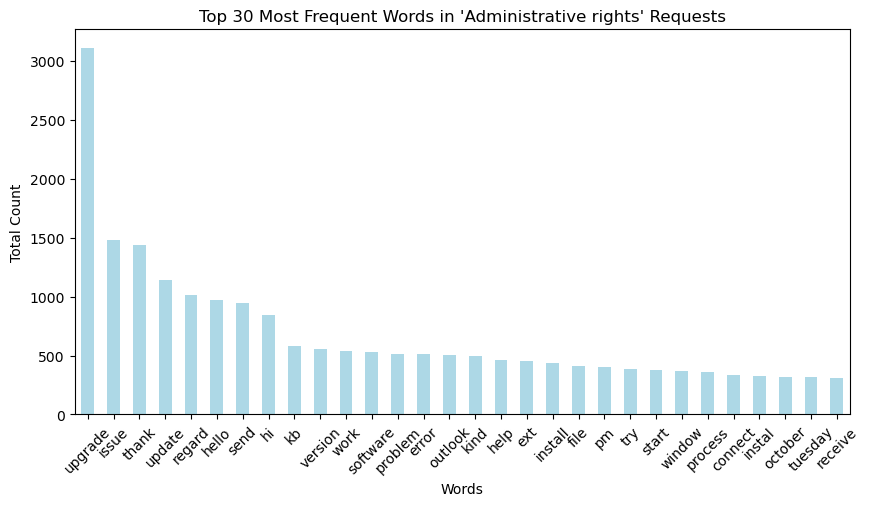

upgrade     3111
issue       1483
thank       1439
update      1144
regard      1018
hello        972
send         950
hi           841
kb           578
version      555
work         536
software     530
problem      514
error        512
outlook      504
kind         500
help         465
ext          458
install      437
file         408
pm           399
try          385
start        376
window       366
process      357
connect      335
instal       323
october      318
tuesday      317
receive      306
dtype: int64


In [ ]:
all_tickets_bow_df_Administrative_rights = all_tickets_bow_df[all_tickets_bow_df["Topic_group"] == "Administrative rights"]
word_counts = all_tickets_bow_df_Administrative_rights.drop(columns=["Topic_group"]).sum()
top_30_words = word_counts.sort_values(ascending=False).head(30)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
top_30_words.plot(kind="bar", color="lightblue")
plt.xlabel("Words")
plt.ylabel("Total Count")
plt.title("Top 30 Most Frequent Words in 'Administrative rights' Requests")
plt.xticks(rotation=45)
plt.show()

print(top_30_words)


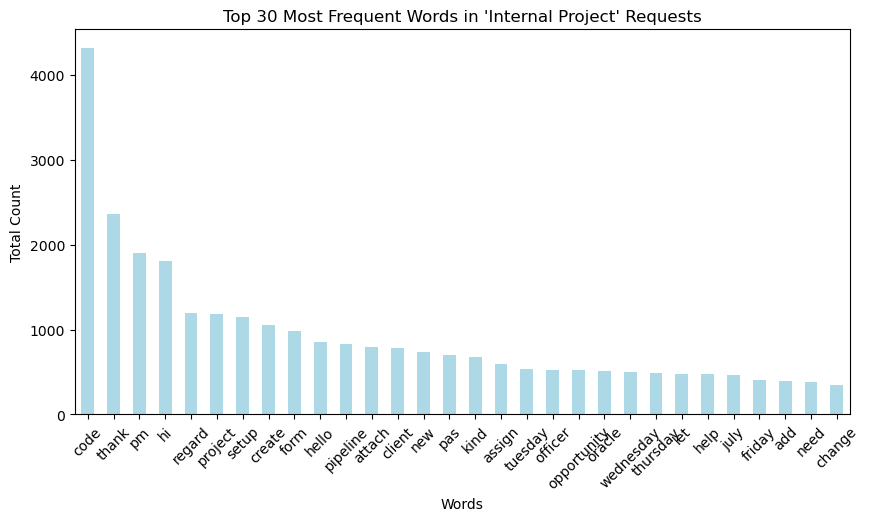

code           4316
thank          2355
pm             1903
hi             1804
regard         1199
project        1181
setup          1147
create         1057
form            978
hello           854
pipeline        835
attach          792
client          784
new             730
pas             699
kind            672
assign          595
tuesday         535
officer         522
opportunity     520
oracle          507
wednesday       495
thursday        486
let             475
help            472
july            470
friday          404
add             388
need            387
change          350
dtype: int64


In [ ]:
all_tickets_bow_df_Internal_Project = all_tickets_bow_df[all_tickets_bow_df["Topic_group"] == "Internal Project"]
word_counts = all_tickets_bow_df_Internal_Project.drop(columns=["Topic_group"]).sum()
top_30_words = word_counts.sort_values(ascending=False).head(30)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
top_30_words.plot(kind="bar", color="lightblue")
plt.xlabel("Words")
plt.ylabel("Total Count")
plt.title("Top 30 Most Frequent Words in 'Internal Project' Requests")
plt.xticks(rotation=45)
plt.show()

print(top_30_words)

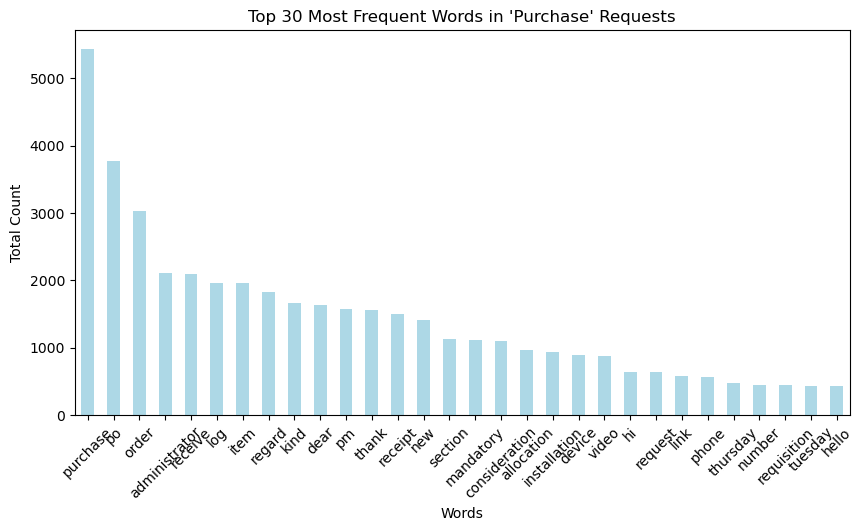

purchase         5440
po               3764
order            3031
administrator    2112
receive          2099
log              1967
item             1955
regard           1825
kind             1658
dear             1640
pm               1578
thank            1560
receipt          1502
new              1411
section          1123
mandatory        1115
consideration    1101
allocation        971
installation      931
device            890
video             875
hi                642
request           640
link              577
phone             562
thursday          474
number            444
requisition       441
tuesday           439
hello             439
dtype: int64


In [ ]:
all_tickets_bow_df_Purchase = all_tickets_bow_df[all_tickets_bow_df["Topic_group"] == "Purchase"]
word_counts = all_tickets_bow_df_Purchase.drop(columns=["Topic_group"]).sum()
top_30_words = word_counts.sort_values(ascending=False).head(30)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
top_30_words.plot(kind="bar", color="lightblue")
plt.xlabel("Words")
plt.ylabel("Total Count")
plt.title("Top 30 Most Frequent Words in 'Purchase' Requests")
plt.xticks(rotation=45)
plt.show()

print(top_30_words)

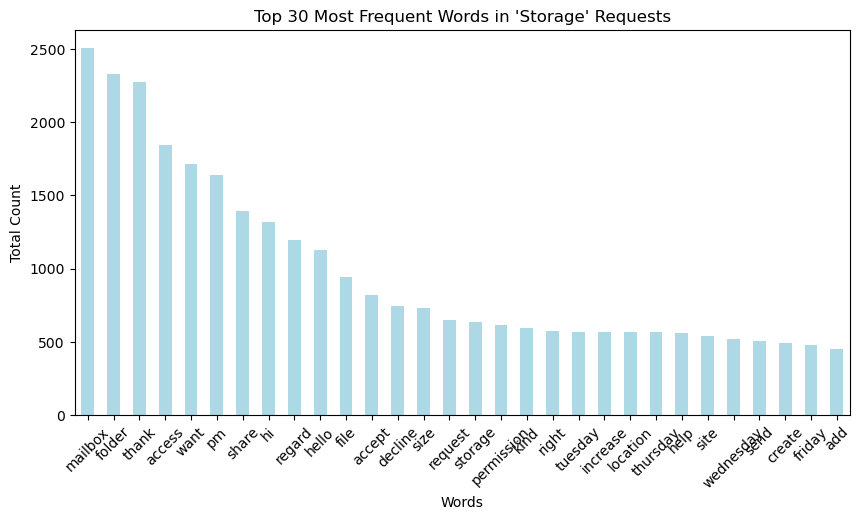

mailbox       2503
folder        2326
thank         2272
access        1843
want          1717
pm            1636
share         1395
hi            1315
regard        1196
hello         1124
file           944
accept         819
decline        747
size           734
request        649
storage        636
permission     615
kind           592
right          575
tuesday        569
increase       567
location       566
thursday       564
help           557
site           540
wednesday      520
send           505
create         491
friday         475
add            453
dtype: int64


In [ ]:
all_tickets_bow_df_Storage = all_tickets_bow_df[all_tickets_bow_df["Topic_group"] == "Storage"]
word_counts = all_tickets_bow_df_Storage.drop(columns=["Topic_group"]).sum()
top_30_words = word_counts.sort_values(ascending=False).head(30)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
top_30_words.plot(kind="bar", color="lightblue")
plt.xlabel("Words")
plt.ylabel("Total Count")
plt.title("Top 30 Most Frequent Words in 'Storage' Requests")
plt.xticks(rotation=45)
plt.show()

print(top_30_words)

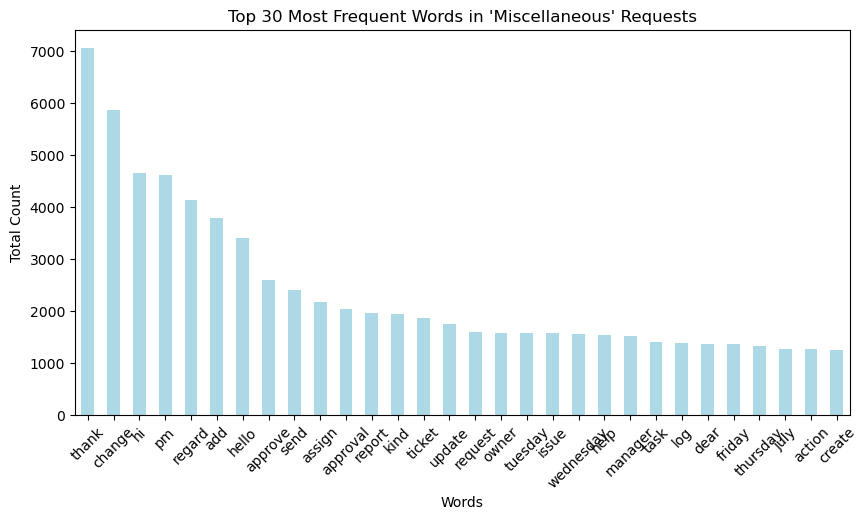

thank        7046
change       5853
hi           4660
pm           4605
regard       4140
add          3778
hello        3405
approve      2597
send         2402
assign       2181
approval     2036
report       1954
kind         1933
ticket       1866
update       1759
request      1592
owner        1571
tuesday      1571
issue        1570
wednesday    1550
help         1540
manager      1518
task         1413
log          1379
dear         1367
friday       1356
thursday     1332
july         1276
action       1264
create       1253
dtype: int64


In [ ]:
all_tickets_bow_df_Miscellaneous = all_tickets_bow_df[all_tickets_bow_df["Topic_group"] == "Miscellaneous"]
word_counts = all_tickets_bow_df_Miscellaneous.drop(columns=["Topic_group"]).sum()
top_30_words = word_counts.sort_values(ascending=False).head(30)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
top_30_words.plot(kind="bar", color="lightblue")
plt.xlabel("Words")
plt.ylabel("Total Count")
plt.title("Top 30 Most Frequent Words in 'Miscellaneous' Requests")
plt.xticks(rotation=45)
plt.show()

print(top_30_words)

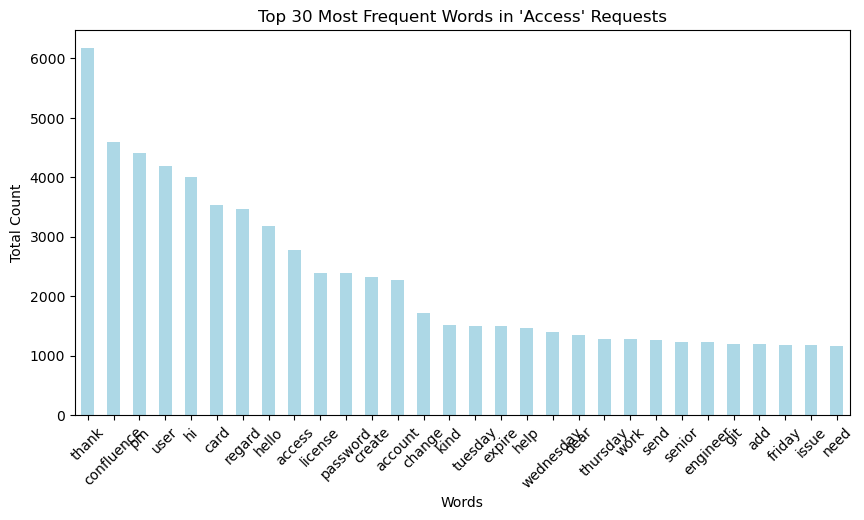

thank         6166
confluence    4587
pm            4401
user          4186
hi            4001
card          3533
regard        3463
hello         3182
access        2775
license       2395
password      2385
create        2319
account       2277
change        1719
kind          1517
tuesday       1493
expire        1490
help          1470
wednesday     1404
dear          1347
thursday      1284
work          1282
send          1268
senior        1234
engineer      1229
git           1199
add           1199
friday        1186
issue         1177
need          1158
dtype: int64


In [ ]:
all_tickets_bow_df_Access = all_tickets_bow_df[all_tickets_bow_df["Topic_group"] == "Access"]
word_counts = all_tickets_bow_df_Access.drop(columns=["Topic_group"]).sum()
top_30_words = word_counts.sort_values(ascending=False).head(30)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
top_30_words.plot(kind="bar", color="lightblue")
plt.xlabel("Words")
plt.ylabel("Total Count")
plt.title("Top 30 Most Frequent Words in 'Access' Requests")
plt.xticks(rotation=45)
plt.show()

print(top_30_words)

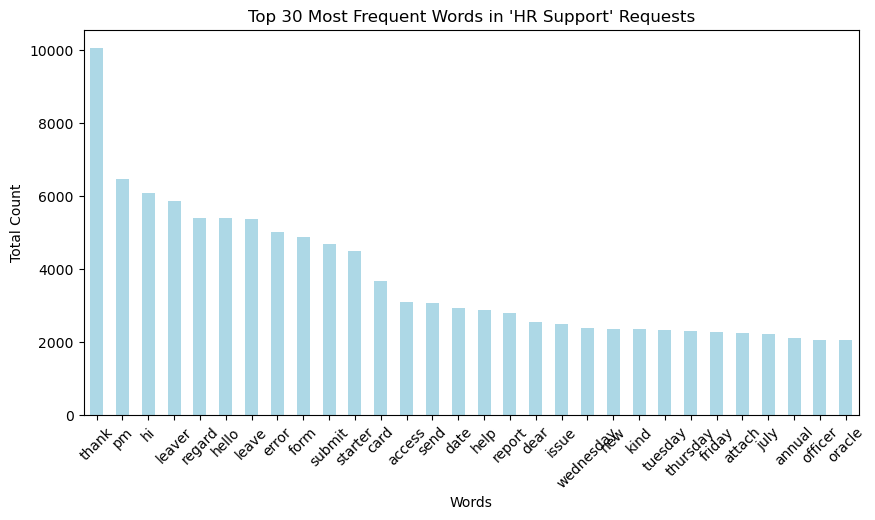

thank        10041
pm            6477
hi            6092
leaver        5859
regard        5397
hello         5383
leave         5358
error         5020
form          4885
submit        4678
starter       4494
card          3667
access        3097
send          3060
date          2945
help          2870
report        2799
dear          2542
issue         2482
wednesday     2374
new           2359
kind          2356
tuesday       2339
thursday      2291
friday        2279
attach        2239
july          2230
annual        2113
officer       2065
oracle        2057
dtype: int64


In [ ]:
all_tickets_bow_df_HR_Support = all_tickets_bow_df[all_tickets_bow_df["Topic_group"] == "HR Support"]
word_counts = all_tickets_bow_df_HR_Support.drop(columns=["Topic_group"]).sum()
top_30_words = word_counts.sort_values(ascending=False).head(30)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
top_30_words.plot(kind="bar", color="lightblue")
plt.xlabel("Words")
plt.ylabel("Total Count")
plt.title("Top 30 Most Frequent Words in 'HR Support' Requests")
plt.xticks(rotation=45)
plt.show()

print(top_30_words)

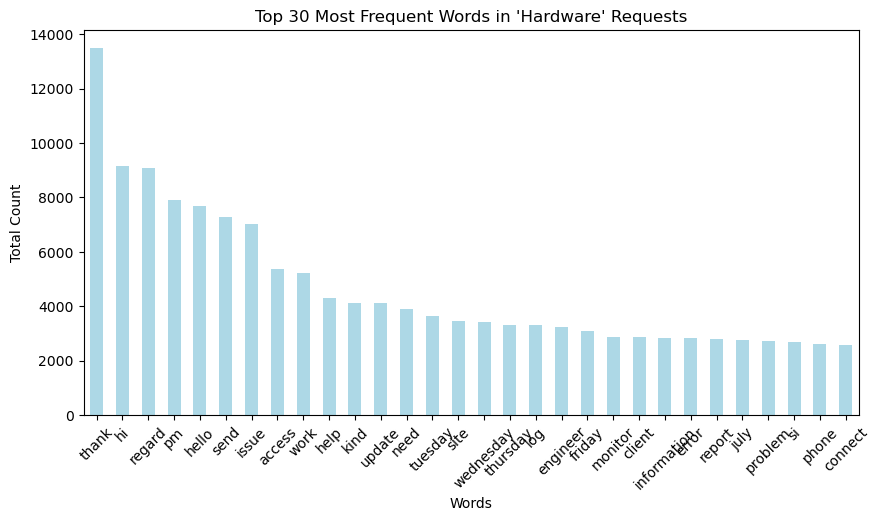

thank          13482
hi              9143
regard          9075
pm              7903
hello           7666
send            7274
issue           7007
access          5360
work            5238
help            4285
kind            4130
update          4100
need            3883
tuesday         3636
site            3468
wednesday       3413
thursday        3308
log             3302
engineer        3242
friday          3105
monitor         2882
client          2875
information     2833
error           2822
report          2796
july            2767
problem         2734
si              2688
phone           2611
connect         2584
dtype: int64


In [ ]:
all_tickets_bow_df_Hardware = all_tickets_bow_df[all_tickets_bow_df["Topic_group"] == "Hardware"]
word_counts = all_tickets_bow_df_Hardware.drop(columns=["Topic_group"]).sum()
top_30_words = word_counts.sort_values(ascending=False).head(30)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
top_30_words.plot(kind="bar", color="lightblue")
plt.xlabel("Words")
plt.ylabel("Total Count")
plt.title("Top 30 Most Frequent Words in 'Hardware' Requests")
plt.xticks(rotation=45)
plt.show()

print(top_30_words)

To reduce noise, we'll drop the high-frequency words "hello", "hi", "regard", and "thank" from `all_tickets_bow_df`.

In [79]:
all_tickets_bow_df = all_tickets_bow_df.drop(columns=["hi", "hello", "regard", "thank"])

We now split the data into train and test sets. We'll use the `stratify=y` parameter in `train_test_split` to ensure the class distribution in the train and test sets matches the distribution in the original `all_tickets` data.

In [80]:
from sklearn.model_selection import train_test_split

X = all_tickets_bow_df.drop(columns=["Topic_group"])
y = all_tickets_bow_df["Topic_group"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"Test set: {X_test.shape[0]} rows and {X_test.shape[1]} columns")

Training set: 38269 rows and 9293 columns
Test set: 9568 rows and 9293 columns


## Model Building and Analysis

### Logistic Regression (unweighted)

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_reg_unweighted = LogisticRegression(max_iter=1000, random_state=42)
log_reg_unweighted.fit(X_train, y_train)
y_pred_log_reg_unweighted = log_reg_unweighted.predict(X_test)

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg_unweighted):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_reg_unweighted))

Logistic Regression Performance:
Accuracy: 0.8336

Classification Report:
                        precision    recall  f1-score   support

               Access       0.88      0.88      0.88      1425
Administrative rights       0.79      0.70      0.74       352
           HR Support       0.83      0.84      0.84      2183
             Hardware       0.80      0.82      0.81      2724
     Internal Project       0.87      0.84      0.85       424
        Miscellaneous       0.79      0.79      0.79      1412
             Purchase       0.95      0.88      0.92       493
              Storage       0.88      0.88      0.88       555

             accuracy                           0.83      9568
            macro avg       0.85      0.83      0.84      9568
         weighted avg       0.83      0.83      0.83      9568



### Logistic Regression (weighted)

In [82]:
log_reg_weighted = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg_weighted.fit(X_train, y_train)
y_pred_log_reg_weighted = log_reg_weighted.predict(X_test)

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg_weighted):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_reg_weighted))

Logistic Regression Performance:
Accuracy: 0.8272

Classification Report:
                        precision    recall  f1-score   support

               Access       0.87      0.89      0.88      1425
Administrative rights       0.63      0.80      0.71       352
           HR Support       0.85      0.83      0.84      2183
             Hardware       0.85      0.76      0.80      2724
     Internal Project       0.77      0.90      0.83       424
        Miscellaneous       0.77      0.82      0.80      1412
             Purchase       0.89      0.91      0.90       493
              Storage       0.84      0.91      0.87       555

             accuracy                           0.83      9568
            macro avg       0.81      0.85      0.83      9568
         weighted avg       0.83      0.83      0.83      9568



### KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

KNN Performance:
Accuracy: 0.7181

Classification Report:
                        precision    recall  f1-score   support

               Access       0.76      0.81      0.79      1425
Administrative rights       0.59      0.52      0.55       352
           HR Support       0.59      0.88      0.71      2183
             Hardware       0.80      0.62      0.70      2724
     Internal Project       0.80      0.67      0.73       424
        Miscellaneous       0.74      0.59      0.66      1412
             Purchase       0.95      0.84      0.89       493
              Storage       0.85      0.72      0.78       555

             accuracy                           0.72      9568
            macro avg       0.76      0.71      0.72      9568
         weighted avg       0.74      0.72      0.72      9568



### Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Performance:
Accuracy: 0.7652

Classification Report:
                        precision    recall  f1-score   support

               Access       0.83      0.84      0.84      1425
Administrative rights       0.73      0.68      0.71       352
           HR Support       0.79      0.78      0.78      2183
             Hardware       0.74      0.74      0.74      2724
     Internal Project       0.73      0.77      0.75       424
        Miscellaneous       0.69      0.71      0.70      1412
             Purchase       0.88      0.83      0.85       493
              Storage       0.82      0.77      0.80       555

             accuracy                           0.77      9568
            macro avg       0.77      0.77      0.77      9568
         weighted avg       0.77      0.77      0.77      9568



### Random Forest (100 estimators)

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf1.fit(X_train, y_train)
y_pred_rf1 = rf1.predict(X_test)

print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf1):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf1))

Random Forest Performance:
Accuracy: 0.8314

Classification Report:
                        precision    recall  f1-score   support

               Access       0.88      0.86      0.87      1425
Administrative rights       0.92      0.59      0.72       352
           HR Support       0.83      0.86      0.85      2183
             Hardware       0.77      0.87      0.81      2724
     Internal Project       0.89      0.80      0.85       424
        Miscellaneous       0.81      0.76      0.79      1412
             Purchase       0.97      0.86      0.91       493
              Storage       0.94      0.81      0.87       555

             accuracy                           0.83      9568
            macro avg       0.88      0.80      0.83      9568
         weighted avg       0.84      0.83      0.83      9568



### Random Forest (300 estimators)

In [12]:
rf2 = RandomForestClassifier(n_estimators=300, random_state=42)
rf2.fit(X_train, y_train)
y_pred_rf2 = rf2.predict(X_test)

print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf2):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf2))

Random Forest Performance:
Accuracy: 0.8378

Classification Report:
                        precision    recall  f1-score   support

               Access       0.90      0.86      0.88      1425
Administrative rights       0.94      0.59      0.73       352
           HR Support       0.85      0.86      0.85      2183
             Hardware       0.77      0.88      0.82      2724
     Internal Project       0.89      0.80      0.84       424
        Miscellaneous       0.81      0.78      0.79      1412
             Purchase       0.96      0.86      0.91       493
              Storage       0.94      0.81      0.87       555

             accuracy                           0.84      9568
            macro avg       0.88      0.80      0.84      9568
         weighted avg       0.84      0.84      0.84      9568



### Random Forest (600 estimators)

In [84]:
rf3 = RandomForestClassifier(n_estimators=600, random_state=42)
rf3.fit(X_train, y_train)
y_pred_rf3 = rf3.predict(X_test)

print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf3):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf3))

Random Forest Performance:
Accuracy: 0.8424

Classification Report:
                        precision    recall  f1-score   support

               Access       0.90      0.87      0.89      1425
Administrative rights       0.92      0.64      0.75       352
           HR Support       0.85      0.87      0.86      2183
             Hardware       0.78      0.88      0.83      2724
     Internal Project       0.89      0.79      0.84       424
        Miscellaneous       0.81      0.78      0.79      1412
             Purchase       0.96      0.86      0.91       493
              Storage       0.94      0.81      0.87       555

             accuracy                           0.84      9568
            macro avg       0.88      0.81      0.84      9568
         weighted avg       0.85      0.84      0.84      9568



### Support Vector Machine (linear)

In [14]:
from sklearn.svm import SVC

svm_linear = SVC(kernel="linear", random_state=42)
svm_linear.fit(X_train, y_train)
y_pred_svm_linear = svm_linear.predict(X_test)

print("SVM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_linear):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm_linear))

SVM Performance:
Accuracy: 0.8308

Classification Report:
                        precision    recall  f1-score   support

               Access       0.86      0.90      0.88      1425
Administrative rights       0.77      0.72      0.74       352
           HR Support       0.81      0.85      0.83      2183
             Hardware       0.82      0.81      0.82      2724
     Internal Project       0.86      0.83      0.85       424
        Miscellaneous       0.80      0.77      0.78      1412
             Purchase       0.93      0.90      0.92       493
              Storage       0.89      0.86      0.87       555

             accuracy                           0.83      9568
            macro avg       0.84      0.83      0.84      9568
         weighted avg       0.83      0.83      0.83      9568



### Support Vector Machine (RBF kernel)

In [15]:
from sklearn.svm import SVC

svm_rbf = SVC(kernel="rbf", random_state=42)
svm_rbf.fit(X_train, y_train)
y_pred_svm_rbf = svm_rbf.predict(X_test)

print("SVM Performance (RBF):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_rbf):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm_rbf))

SVM Performance (RBF):
Accuracy: 0.8304

Classification Report:
                        precision    recall  f1-score   support

               Access       0.89      0.85      0.87      1425
Administrative rights       0.90      0.59      0.71       352
           HR Support       0.84      0.85      0.85      2183
             Hardware       0.75      0.88      0.81      2724
     Internal Project       0.89      0.75      0.82       424
        Miscellaneous       0.83      0.76      0.79      1412
             Purchase       0.97      0.87      0.92       493
              Storage       0.93      0.81      0.86       555

             accuracy                           0.83      9568
            macro avg       0.88      0.80      0.83      9568
         weighted avg       0.84      0.83      0.83      9568



### AdaBoost (100 estimators)

In [16]:
from sklearn.ensemble import AdaBoostClassifier

adaboost1 = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost1.fit(X_train, y_train)
y_pred_ab1 = adaboost1.predict(X_test)

print("AdaBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ab1):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_ab1))

AdaBoost Performance:
Accuracy: 0.4278

Classification Report:
                        precision    recall  f1-score   support

               Access       0.90      0.13      0.23      1425
Administrative rights       0.80      0.19      0.31       352
           HR Support       0.72      0.27      0.40      2183
             Hardware       0.34      0.93      0.50      2724
     Internal Project       0.80      0.46      0.59       424
        Miscellaneous       0.25      0.06      0.10      1412
             Purchase       0.97      0.66      0.79       493
              Storage       0.83      0.17      0.28       555

             accuracy                           0.43      9568
            macro avg       0.70      0.36      0.40      9568
         weighted avg       0.60      0.43      0.38      9568



### AdaBoost (300 estimators)

In [17]:
base_estimator = DecisionTreeClassifier(max_depth=3, random_state=42)
adaboost2 = AdaBoostClassifier(estimator=base_estimator, n_estimators=300, random_state=42)
adaboost2.fit(X_train, y_train)
y_pred_ab2 = adaboost2.predict(X_test)


print("AdaBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ab2):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_ab2))


AdaBoost Performance:
Accuracy: 0.7240

Classification Report:
                        precision    recall  f1-score   support

               Access       0.84      0.72      0.78      1425
Administrative rights       0.78      0.62      0.69       352
           HR Support       0.78      0.70      0.74      2183
             Hardware       0.60      0.81      0.69      2724
     Internal Project       0.76      0.76      0.76       424
        Miscellaneous       0.71      0.56      0.62      1412
             Purchase       0.94      0.85      0.89       493
              Storage       0.90      0.73      0.81       555

             accuracy                           0.72      9568
            macro avg       0.79      0.72      0.75      9568
         weighted avg       0.74      0.72      0.73      9568



### AdaBoost (600 estimators)

In [18]:
base_estimator = DecisionTreeClassifier(max_depth=4, random_state=42)
adaboost3 = AdaBoostClassifier(estimator=base_estimator, n_estimators=600, random_state=42)
adaboost3.fit(X_train, y_train)
y_pred_ab3 = adaboost3.predict(X_test)

print("AdaBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ab3):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_ab3))

AdaBoost Performance:
Accuracy: 0.7504

Classification Report:
                        precision    recall  f1-score   support

               Access       0.84      0.78      0.81      1425
Administrative rights       0.66      0.68      0.67       352
           HR Support       0.81      0.75      0.78      2183
             Hardware       0.67      0.76      0.72      2724
     Internal Project       0.63      0.85      0.72       424
        Miscellaneous       0.76      0.61      0.68      1412
             Purchase       0.85      0.88      0.86       493
              Storage       0.84      0.79      0.82       555

             accuracy                           0.75      9568
            macro avg       0.76      0.76      0.76      9568
         weighted avg       0.76      0.75      0.75      9568



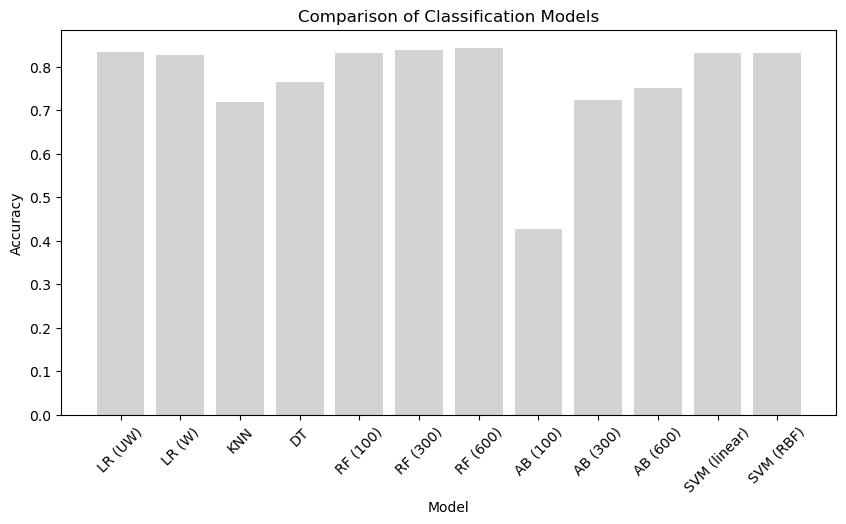

In [85]:
model_scores = {
    "LR (UW)": accuracy_score(y_test, y_pred_log_reg_unweighted),
    "LR (W)": accuracy_score(y_test, y_pred_log_reg_weighted),
    "KNN": accuracy_score(y_test, y_pred_knn),
    "DT": accuracy_score(y_test, y_pred_dt),
    "RF (100)": accuracy_score(y_test, y_pred_rf1),
    "RF (300)": accuracy_score(y_test, y_pred_rf2),
    "RF (600)": accuracy_score(y_test, y_pred_rf3),
    "AB (100)": accuracy_score(y_test, y_pred_ab1),
    "AB (300)": accuracy_score(y_test, y_pred_ab2),
    "AB (600)": accuracy_score(y_test, y_pred_ab3),
    "SVM (linear)": accuracy_score(y_test, y_pred_svm_linear),
    "SVM (RBF)": accuracy_score(y_test, y_pred_svm_rbf)
}

plt.figure(figsize=(10, 5))
plt.bar(model_scores.keys(), model_scores.values(), color="lightgrey")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Classification Models")
plt.xticks(rotation=45)
plt.show()

### Model Training Time (mac M1 processor - single core utilization)

| Model | Training Time |
|-------|---------------|
|Logistic Regression (unweighted)| 1 minute 37 seconds|
|Logistic Regression (weighted)| 1 minute 19 seconds|
|KNN |1 minute 4 seconds|
|Decision Tree |23 seconds|
|Random Forest (100 estimators) |1 minute 23 seconds|
|Random Forest (300 estimators) |3 minutes 59 seconds|
|Random Forest (600 estimators) |7 minutes 55 seconds|
|Support Vector Machine (linear) |28 minutes 46 seconds|
|Support Vector Machine (RBF kernel) |49 minutes 52 seconds|
|AdaBoost (100 estimators) |3 minutes 17 seconds|
|AdaBoost (300 estimators) |16 minutes 4 seconds|
|AdaBoost (600 estimators) |39 minutes 31 seconds|

### Reflections on Model Performance

Among the models evaluated, **Logistic Regression** performed notably well, achieving an accuracy of **83.3%**, which was nearly equivalent to the best-performing model—**Random Forest**. This outcome is particularly striking given the simplicity of Logistic Regression, suggesting that a linear decision boundary is sufficient to capture a significant portion of the underlying patterns in the data. Additionally, Logistic Regression offered the advantage of **fast training time** (approximately 1.5 minutes), making it a practical choice for rapid iteration.

A significant challenge in this project was the **high dimensionality** of the dataset, with nearly **10,000 bag-of-words features**. This complexity likely impacted the performance of **Support Vector Machines (SVM)**, both with linear and RBF kernels. Training times were substantial—around **29 minutes for the linear SVM** and nearly **50 minutes for the RBF variant**—making them less viable for experimentation in this context.

The performance of **AdaBoost** was unexpectedly low, with a maximum accuracy of only **~75%**. Given that AdaBoost is built on decision trees, it was initially assumed to perform comparably to Random Forest. However, its reliance on boosting weak learners may be less effective in a high-dimensional feature space, where simple decision stumps are insufficient for capturing complex patterns. Despite increasing the number of learners and the maximum depth (up to 300 learners), improvements were marginal. Further increasing model complexity could enhance performance, but this comes at the cost of significantly higher computational demands—placing AdaBoost among the most resource-intensive models tested, alongside SVM.

**Random Forest**, on the other hand, emerged as the top performer, balancing accuracy and interpretability. Given its strong results, it was selected for further hyperparameter tuning in the subsequent phase of the project.

### Hyperparameter Tuning for Random Forest

Given that the Random Forest model achieved the highest accuracy in the initial evaluation, I proceeded to explore **hyperparameter tuning** to determine whether performance could be further optimized. Specifically, I focused on the impact of **limiting tree depth**, hypothesizing that unrestricted tree growth may lead to **overfitting**, reducing the model’s generalization to unseen data.

The earlier `rf3` model was trained with the default setting `max_depth=None`, allowing trees to grow until nodes are pure (i.e., each leaf contains only a single class). While this can increase training accuracy, it often results in models that are overly complex and prone to overfitting. To address this, I tested whether **constraining the depth** of the trees could improve model generalization.

To evaluate this, I conducted a **grid search** over a range of hyperparameters, with particular focus on varying tree depth. The grid search included the following parameters:

- **n_estimators**: Number of trees in the ensemble.  
- **max_depth**: Maximum depth of each tree (tested at 10, 20, and 30).  
- **min_samples_split**: Minimum number of samples required to split an internal node.  
- **min_samples_leaf**: Minimum number of samples required to be present at a leaf node.

The grid search was performed using **3-fold cross-validation** on the training set to assess how different combinations of these hyperparameters influenced model performance. The primary goal was to test the hypothesis that limiting tree depth could reduce overfitting and lead to better validation accuracy.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    'n_estimators': [600, 800, 1000],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid,
                              cv=3, verbose=2, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

print("Best Parameters:", rf_grid_search.best_params_)
print("Best Accuracy:", rf_grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 1.3min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 1.3min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 1.3min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 1.4min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 1.6min
[CV] END max_depth=10, min_

The results indicate that setting `max_depth` to 30 **does not yield a meaningful improvement in accuracy** compared to the default configuration used in the `rf3` model, where `max_depth` is unrestricted. This suggests that the original hypothesis—that limiting tree depth would enhance generalization and reduce overfitting—was likely incorrect for this dataset.

Moreover, the grid search results show that using the **lowest values for `min_samples_leaf` (1)** and **`min_samples_split` (2)** continues to produce the best-performing models. This further supports the conclusion that **deeper trees** remain more effective for capturing the complexity of this particular classification task, and that more aggressive regularization through depth constraints may unnecessarily limit the model’s learning capacity.

### Hyperparameter Tuning Heatmap Visualization

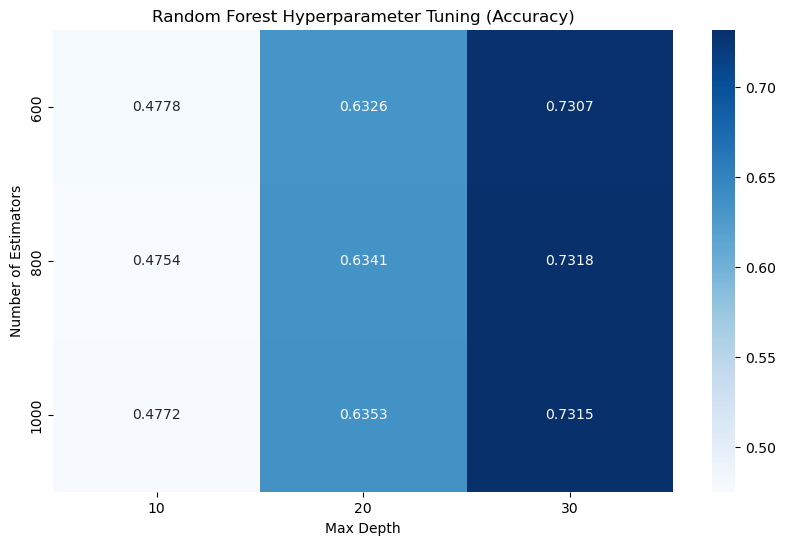

In [41]:
import seaborn as sns

results = rf_grid_search.cv_results_
df_results = pd.DataFrame(results)

df_results = df_results[['param_n_estimators', 'param_max_depth', 'mean_test_score']]
df_results['param_n_estimators'] = df_results['param_n_estimators'].astype(int)
df_results['param_max_depth'] = df_results['param_max_depth'].astype(int)

df_results = df_results.groupby(['param_n_estimators', 'param_max_depth'])['mean_test_score'].mean().reset_index()
df_pivot = df_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot, annot=True, fmt=".4f", cmap="Blues")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.title("Random Forest Hyperparameter Tuning (Accuracy)")
plt.show()


The results show that **increasing `max_depth` from 10 to 30 leads to a noticeable improvement in accuracy**, indicating that deeper trees are better able to capture the complexity of the data. However, **increasing the number of trees (`n_estimators`) beyond 800** appears to provide **diminishing returns**, with only marginal or negligible gains in performance. This suggests that while tree depth plays a significant role in model accuracy, simply adding more trees beyond a certain point may not be an efficient strategy for further improvement.

## Conclusion

The goal of this project was to develop a machine learning classifier capable of automatically categorizing IT support tickets—a crucial step toward building an intelligent system for routing requests to the appropriate resolution teams.

Among the models evaluated, **Random Forest consistently delivered the strongest performance**, achieving an accuracy of approximately **83–84%** on the test set. This demonstrated its effectiveness in handling high-dimensional, text-based data using a Bag-of-Words representation.

To further refine the model, I conducted **hyperparameter tuning**, focusing particularly on tree depth and the number of estimators. The results showed that **increasing `max_depth` improved accuracy**, confirming that deeper trees are more effective at capturing the structure of the data. However, **adding more trees beyond 800 estimators provided minimal benefit**, with a slight decline in performance at 1,000 trees—highlighting that additional complexity does not always lead to better outcomes.

While these results are promising, they represent an early step in the development of a production-ready IT ticket classification system. There remains significant potential for further enhancement.

### Future Directions

- **Explore alternative feature extraction methods**, such as TF-IDF or pre-trained word embeddings (e.g., Word2Vec, GloVe, BERT), to capture richer semantic information.
- **Experiment with more advanced models**, including Gradient Boosting algorithms (e.g., XGBoost, LightGBM) or deep learning architectures such as Recurrent Neural Networks or Transformers.
- **Perform more extensive hyperparameter optimization** using larger search spaces and more robust cross-validation techniques.
- **Implement model explainability tools**, such as SHAP or LIME, to better understand which features influence classification decisions.

Overall, this project establishes a strong baseline for IT ticket classification and opens the door for more sophisticated machine learning workflows in enterprise support systems.